# Verifier-RL: Training a Math Reasoner with GRPO + Verifiable Rewards

## What Are We Doing?

We are going to **train a small language model to reason about math** using reinforcement learning — but without a learned reward model.

The standard RLHF pipeline looks like: `SFT → Train Reward Model → PPO`. The reward model is expensive, noisy, and gameable. Instead, we do something cleaner:

1. Give the model a math problem.
2. Let it generate multiple candidate solutions.
3. **Check each answer against the ground truth** using a symbolic verifier (regex extraction + exact match).
4. Use the binary correctness signal as the reward.
5. Train with **Group Relative Policy Optimization (GRPO)** — a variant of PPO that doesn't need a separate value network.

This is called **Verifier-RL** or **outcome-based RL**. The key insight: for math, you don't need a neural network to tell you if the answer is right. You can just... check.

### Why GRPO Over PPO?

PPO requires a value network (critic) that estimates expected future reward. For LLMs, this is another full-sized model — doubling your VRAM. GRPO sidesteps this by computing advantages **within a group of sampled completions** for the same prompt:

$$
\hat{A}_i = \frac{r_i - \text{mean}(\{r_j\}_{j=1}^{G})}{\text{std}(\{r_j\}_{j=1}^{G})}
$$

Where $G$ is the group size (number of completions per prompt) and $r_i$ is the reward for the $i$-th completion. No critic network needed. Half the VRAM. Fits on a single Colab GPU.

### Research Questions

1. Can verifier-based RL outperform pure SFT on math reasoning for a 0.6B model?
2. Does GRPO training remain stable without a learned reward model?
3. How does the model's reasoning style evolve across training steps?
4. Does reward hacking emerge when the reward is binary and verifiable?
5. How does Qwen3's native thinking mode interact with RL-trained reasoning?

**Target model:** `Qwen/Qwen3-0.6B` (28 layers, 1024 hidden dim, thinking/non-thinking modes)  
**Dataset:** GSM8K (grade school math, 7.5k train problems)  
**Algorithm:** GRPO via HuggingFace TRL  
**Hardware:** 1× T4/L4/A100 (Colab Pro)

## Why This Matters

Most RL-for-reasoning work (DeepSeek-R1, OpenAI o1) uses massive models and proprietary reward models. We want to know: **does the core idea scale down?** Can a 0.6B model learn to reason better through RL with nothing but a correctness checker?

If yes, this is a big deal for:
- **Democratizing reasoning research** — anyone with a Colab can reproduce this.
- **Understanding RL dynamics** — small models are easier to analyze.
- **Challenging the SFT ceiling** — does RL unlock capabilities that supervised training can't?

### Why Qwen3?

Qwen3 is the latest generation of the Qwen family (released 2025). The 0.6B variant supports both **thinking mode** (internal chain-of-thought wrapped in `<think>...</think>` tags) and **non-thinking mode** (direct answers). We train in non-thinking mode — the goal is to see if GRPO can teach the model to reason *without* relying on the built-in thinking scaffolding. This makes the RL signal cleaner: any reasoning improvement comes from the gradient updates, not from prompting tricks.

## Step 1: Environment Setup

We need TRL (Transformer Reinforcement Learning) for GRPO, along with the usual suspects. TRL wraps the entire GRPO training loop — group sampling, advantage computation, policy gradient updates, and KL penalty — into a clean trainer API.

We also install `vllm` for fast batched inference during the group sampling phase. GRPO needs to generate $G$ completions per prompt, so inference speed is the bottleneck.

**Note:** Qwen3 requires `transformers>=4.51.0` for proper support.

In [1]:
!pip install -q "trl>=0.15.0" "transformers>=4.51.0" accelerate datasets peft bitsandbytes
!pip install -q "vllm>=0.10.2,<=0.12.0" --no-build-isolation
!pip install -q flash-attn --no-build-isolation
!pip install -q "protobuf>=3.20,<5"  # Fix MessageFactory error

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.8/528.8 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.5/466.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.0/355.0 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.0/183.0 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 142.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 125.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import torch
import re
import gc
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import GRPOConfig, GRPOTrainer

# Verify GPU availability
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

CUDA available: True
GPU: NVIDIA A100-SXM4-40GB
VRAM: 42.4 GB


## Step 2: Load and Prepare GSM8K

GSM8K is a dataset of 7,473 grade school math word problems. Each problem has a natural language solution with a final numerical answer marked with `#### <number>`.

We need to do two things:
1. **Extract the ground truth answer** from the `####` marker for our verifier.
2. **Format prompts** so the model knows we want step-by-step reasoning with a boxed final answer.

The prompt format is critical. We explicitly ask the model to show its work and put the final answer in `\boxed{}`. This gives us a clean extraction target for the reward function.

In [3]:
dataset = load_dataset("openai/gsm8k", "main", split="train")
test_dataset = load_dataset("openai/gsm8k", "main", split="test")

print(f"Train: {len(dataset)} problems")
print(f"Test: {len(test_dataset)} problems")
print(f"\nExample problem:")
print(f"Q: {dataset[0]['question']}")
print(f"A: {dataset[0]['answer']}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Train: 7473 problems
Test: 1319 problems

Example problem:
Q: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
A: Natalia sold 48/2 = <<48/2=24>>24 clips in May.
Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.
#### 72


In [4]:
SYSTEM_PROMPT = (
    "You are a math tutor. Solve the problem step by step. "
    "Show your reasoning clearly, then put your final numerical answer "
    "inside \\boxed{}. For example: \\boxed{42}"
)


def extract_gsm8k_answer(answer_text: str) -> str:
    """Extract the final numerical answer from GSM8K format.
    GSM8K answers end with '#### <number>'.
    """
    match = re.search(r"####\s*([\d,\.\-]+)", answer_text)
    if match:
        return match.group(1).replace(",", "").strip()
    return ""


def format_for_grpo(example):
    """Format a GSM8K example into the structure GRPO expects.
    TRL's GRPOTrainer expects a 'prompt' field with chat messages.
    """
    return {
        "prompt": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": example["question"]},
        ],
        "ground_truth": extract_gsm8k_answer(example["answer"]),
    }


train_data = dataset.map(format_for_grpo, remove_columns=dataset.column_names)
test_data = test_dataset.map(format_for_grpo, remove_columns=test_dataset.column_names)

# Sanity check
print(f"\nFormatted example:")
print(f"Prompt: {train_data[0]['prompt']}")
print(f"Ground truth: {train_data[0]['ground_truth']}")

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Map:   0%|          | 0/1319 [00:00<?, ? examples/s]


Formatted example:
Prompt: [{'content': 'You are a math tutor. Solve the problem step by step. Show your reasoning clearly, then put your final numerical answer inside \\boxed{}. For example: \\boxed{42}', 'role': 'system'}, {'content': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?', 'role': 'user'}]
Ground truth: 72


## Step 3: The Reward Function — No Neural Network Required

This is the core philosophical choice of this experiment. Instead of training a reward model (which would be another neural network we need to fit in VRAM, train on human preferences, and hope doesn't get hacked), we use a **symbolic verifier**.

The reward function:
1. Extracts the number inside `\boxed{}` from the model's completion.
2. Compares it to the ground truth answer from GSM8K.
3. Returns `1.0` if correct, `0.0` if wrong or unparseable.

That's it. No learned preferences. No reward hacking surface beyond "get the right answer". The only way to maximize this reward is to actually solve the math problem.

We also add a **format reward** as a soft bonus: if the model uses `\boxed{}` at all (even with the wrong answer), it gets a small `0.1` bonus. This encourages the model to learn the output format early in training, which makes the correctness reward more accessible.

$$
r(y) = \begin{cases}
1.0 & \text{if } \text{extract}(y) = \text{ground\_truth} \\
0.1 & \text{if } \texttt{\\boxed\{\}} \text{ present but wrong} \\
0.0 & \text{otherwise}
\end{cases}
$$

In [5]:
def extract_boxed_answer(text: str) -> str:
    """Extract the answer from \\boxed{...} in model output."""
    match = re.search(r"\\boxed\{([^{}]+)\}", text)
    if match:
        answer = match.group(1).strip()
        answer = answer.replace(",", "").replace("$", "").strip(".")
        return answer
    return ""


def extract_final_number(text: str) -> str:
    """Fallback: extract the last number from the model's output.
    Qwen3-0.6B often doesn't use \\boxed{} — it writes things like:
      'The answer is 18' or 'Total = 150 km' or just ends with a number.
    This grabs the last number that looks like a final answer.
    """
    # First try common answer patterns
    patterns = [
        r"(?:the\s+)?answer\s+is\s*:?\s*\$?([+-]?[\d,]+\.?\d*)",
        r"(?:total|result)\s*(?:is|=|:)\s*\$?([+-]?[\d,]+\.?\d*)",
        r"=\s*\$?([+-]?[\d,]+\.?\d*)\s*$",  # ends with = number
        r"\*\*([+-]?[\d,]+\.?\d*)\*\*\s*$",  # bold number at end
        r"(\d[\d,]*\.?\d*)\s*$",              # last number in text
    ]
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE | re.MULTILINE)
        if match:
            return match.group(1).replace(",", "").strip(".")
    return ""


def normalize_number(s: str) -> str:
    """Normalize a number string for comparison."""
    s = s.strip().replace(",", "").replace(" ", "")
    try:
        val = float(s)
        if val == int(val):
            return str(int(val))
        return str(val)
    except ValueError:
        return s


def strip_think_tags(text: str) -> str:
    """Remove <think>...</think> blocks from Qwen3 output."""
    return re.sub(r"<think>.*?</think>", "", text, flags=re.DOTALL).strip()


def _unwrap_completion(completion) -> str:
    """TRL's GRPOTrainer passes completions in different formats depending
    on the version and config. Handle all of them:
      - str: plain text (older TRL / non-chat)
      - list[dict]: chat messages like [{"role": "assistant", "content": "..."}]
      - dict: single message dict like {"role": "assistant", "content": "..."}
    """
    if isinstance(completion, str):
        return completion
    if isinstance(completion, list):
        parts = []
        for msg in completion:
            if isinstance(msg, dict) and "content" in msg:
                parts.append(msg["content"])
            elif isinstance(msg, str):
                parts.append(msg)
        return " ".join(parts)
    if isinstance(completion, dict) and "content" in completion:
        return completion["content"]
    return str(completion)


def extract_answer(text: str) -> str:
    """Try \\boxed{} first, then fall back to number extraction."""
    text = strip_think_tags(text)
    answer = extract_boxed_answer(text)
    if answer:
        return answer
    return extract_final_number(text)


def correctness_reward(completions, ground_truth, **kwargs) -> list[float]:
    """Binary reward: 1.0 if correct, 0.0 if wrong.
    Tries \\boxed{} first, falls back to last-number extraction.
    """
    rewards = []
    for completion, truth in zip(completions, ground_truth):
        text = _unwrap_completion(completion)
        predicted = extract_answer(text)
        if predicted and normalize_number(predicted) == normalize_number(truth):
            rewards.append(1.0)
        else:
            rewards.append(0.0)
    return rewards


def format_reward(completions, **kwargs) -> list[float]:
    """Soft reward for using the \\boxed{} format at all.
    Helps the model learn the output structure early.
    """
    rewards = []
    for completion in completions:
        text = _unwrap_completion(completion)
        text = strip_think_tags(text)
        if re.search(r"\\boxed\{.+\}", text):
            rewards.append(0.1)
        else:
            rewards.append(0.0)
    return rewards


# Quick sanity test
test_completions = [
    "Let me solve this. 3 + 5 = 8. The answer is \\boxed{8}",          # boxed
    "<think>\nhmm\n</think>\nThe answer is 8.",                          # think tags + plain
    "Step 1: 10+5=15. Step 2: 15*2=30. So the total is **30**",        # bold number
    "We get 42 - 7 = 35, and the result is 35",                         # result pattern
]
test_truths = ["8", "8", "30", "35"]

print("Answer extraction test:")
for comp, truth in zip(test_completions, test_truths):
    pred = extract_answer(comp)
    print(f"  Truth={truth}, Predicted={pred}, Match={normalize_number(pred)==normalize_number(truth)}")
    print(f"    Input: {comp[:80]}...")

print(f"\nCorrectness: {correctness_reward(test_completions, test_truths)}")
print(f"Format:      {format_reward(test_completions)}")

Answer extraction test:
  Truth=8, Predicted=8, Match=True
    Input: Let me solve this. 3 + 5 = 8. The answer is \boxed{8}...
  Truth=8, Predicted=8, Match=True
    Input: <think>
hmm
</think>
The answer is 8....
  Truth=30, Predicted=30, Match=True
    Input: Step 1: 10+5=15. Step 2: 15*2=30. So the total is **30**...
  Truth=35, Predicted=35, Match=True
    Input: We get 42 - 7 = 35, and the result is 35...

Correctness: [1.0, 1.0, 1.0, 1.0]
Format:      [0.1, 0.0, 0.0, 0.0]


## Step 4: Load the Base Model

We use **Qwen3-0.6B** as the base model. Why 0.6B?

- **VRAM budget:** GRPO needs to hold the policy model + generate $G$ completions per prompt. With a 7B model and group size 4, you'd need ~40GB just for inference. 0.6B fits comfortably on a T4 (16GB) even with the training overhead.
- **Research signal clarity:** With a small model, any improvement from RL is unambiguously due to the algorithm, not due to the model already knowing the answer from pretraining.
- **Iteration speed:** Each GRPO step takes ~30s instead of ~5min. We can run meaningful experiments in 1-2 hours.
- **Thinking mode control:** Qwen3 supports `/think` and `/no_think` modes. We disable thinking mode to isolate the RL training signal — any reasoning improvement is from GRPO, not from the built-in CoT scaffolding.

The tradeoff: 0.6B models are still small enough to be bad at math out of the box. GSM8K baseline accuracy is typically ~35-45%. This is actually ideal — there's a lot of room for RL to improve things.

In [6]:
MODEL_ID = "Qwen/Qwen3-0.6B"

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"Model: {MODEL_ID}")
print(f"Vocab size: {tokenizer.vocab_size}")
print(f"Pad token: {tokenizer.pad_token}")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Model: Qwen/Qwen3-0.6B
Vocab size: 151643
Pad token: <|endoftext|>


## Step 5: Pre-Training Baseline Evaluation

Before we train anything, let's measure how well the base model does on GSM8K. This gives us the **SFT ceiling** — the model was instruction-tuned during pretraining, so its current performance represents what supervised learning achieved.

We'll test on a subset of the test set (100 problems) to keep evaluation fast. We evaluate with greedy decoding (temperature=0) for reproducibility.

In [7]:
# Load model for baseline evaluation
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
base_model.eval()


def evaluate_model(model, tokenizer, eval_data, n_samples=100, max_new_tokens=512):
    """Evaluate model on GSM8K test set."""
    correct = 0
    total = 0
    format_ok = 0
    examples = []  # Store a few for inspection

    for i in range(min(n_samples, len(eval_data))):
        prompt = eval_data[i]["prompt"]
        truth = eval_data[i]["ground_truth"]

        # Use enable_thinking=False to properly disable Qwen3's thinking mode
        # (appending "/no_think" as text doesn't reliably work)
        chat_kwargs = dict(
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt",
            return_dict=True,
        )
        # Qwen3 tokenizers support enable_thinking parameter
        try:
            inputs = tokenizer.apply_chat_template(
                prompt, enable_thinking=False, **chat_kwargs
            ).to(model.device)
        except TypeError:
            # Fallback for tokenizers that don't support enable_thinking
            inputs = tokenizer.apply_chat_template(
                prompt, **chat_kwargs
            ).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,  # Greedy for reproducibility
            )

        input_len = inputs["input_ids"].shape[1]
        completion = tokenizer.decode(outputs[0][input_len:], skip_special_tokens=True)

        # Strip <think> tags in case they still appear
        completion = strip_think_tags(completion)

        predicted = extract_answer(completion)
        is_correct = (
            predicted != ""
            and normalize_number(predicted) == normalize_number(truth)
        )

        has_boxed = bool(re.search(r"\\boxed\{.+\}", completion))
        if has_boxed:
            format_ok += 1
        if is_correct:
            correct += 1
        total += 1

        # Store first 5 examples
        if len(examples) < 5:
            examples.append({
                "question": prompt[1]["content"][:100],
                "truth": truth,
                "predicted": predicted,
                "correct": is_correct,
                "completion_preview": completion[:200],
            })

        if (i + 1) % 20 == 0:
            print(f"  [{i+1}/{min(n_samples, len(eval_data))}] Running accuracy: {correct/total:.1%}")

    return {
        "accuracy": correct / total,
        "format_rate": format_ok / total,
        "total": total,
        "correct": correct,
        "examples": examples,
    }


print("Evaluating base model (pre-RL)...")
baseline_results = evaluate_model(base_model, tokenizer, test_data, n_samples=100)

print(f"\n{'=' * 50}")
print(f"BASELINE RESULTS (pre-RL)")
print(f"{'=' * 50}")
print(f"Accuracy:    {baseline_results['accuracy']:.1%} ({baseline_results['correct']}/{baseline_results['total']})")
print(f"Format rate: {baseline_results['format_rate']:.1%}")

print(f"\nSample outputs:")
for ex in baseline_results["examples"][:3]:
    print(f"  Q: {ex['question']}...")
    print(f"  Truth: {ex['truth']}, Predicted: {ex['predicted']}, Correct: {ex['correct']}")
    print(f"  Output: {ex['completion_preview'][:150]}...")
    print()

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating base model (pre-RL)...
  [20/100] Running accuracy: 35.0%
  [40/100] Running accuracy: 52.5%
  [60/100] Running accuracy: 55.0%
  [80/100] Running accuracy: 56.2%
  [100/100] Running accuracy: 57.0%

BASELINE RESULTS (pre-RL)
Accuracy:    57.0% (57/100)
Format rate: 97.0%

Sample outputs:
  Q: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for ...
  Truth: 18, Predicted: 18, Correct: True
  Output: Let's break down the problem step by step:

1. **Janet's ducks lay 16 eggs per day.**
2. **She eats 3 eggs for breakfast every morning.**
3. **She bak...

  Q: A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it ...
  Truth: 3, Predicted: 4, Correct: False
  Output: Let's break it down step by step:

- The robe takes **2 bolts of blue fiber**.
- The robe takes **half that much white fiber**, which means **2 bolts ...

  Q: Josh decides to try flipping a house.  He buys a house for $80,

In [8]:
# Free baseline model — we'll load fresh for GRPO training
del base_model
gc.collect()
torch.cuda.empty_cache()

## Step 6: GRPO Training Configuration

Here's where the RL magic happens. Let's break down the key hyperparameters and why we chose them:

### Group Size (`num_generations = 4`)
GRPO generates $G$ completions per prompt, then computes advantages within each group. Larger $G$ = more stable advantage estimates but more VRAM and compute. We use 4 as a sweet spot for T4/L4.

### KL Penalty (`beta = 0.04`)
GRPO adds a KL divergence penalty between the current policy and the reference (initial) policy:

$$
\mathcal{L} = -\hat{A}_i \cdot \log \pi_\theta(y_i | x) + \beta \cdot D_{KL}(\pi_\theta \| \pi_{\text{ref}})
$$

This prevents the model from drifting too far from the pretrained distribution. Too high = model can't learn. Too low = reward hacking.

### Max Completion Length (`max_completion_length = 512`)
GSM8K solutions rarely exceed 300 tokens. We cap at 512 to save compute on the generation phase.

### Training Duration
We train for 250 steps on a T4. This is deliberately short — we want to see if RL shows signal quickly, not burn hours waiting for convergence.

In [11]:
training_args = GRPOConfig(
    # Output
    output_dir="./grpo_gsm8k_output",
    overwrite_output_dir=True,

    # GRPO-specific
    num_generations=4,           # Group size G — completions per prompt
    max_completion_length=512,   # Max tokens per completion
    beta=0.04,                   # KL penalty coefficient

    # Training
    max_steps=250,               # Total training steps
    per_device_train_batch_size=1,  # Prompts per device per step
    gradient_accumulation_steps=4,  # Effective batch = 4 prompts × 4 completions = 16
    learning_rate=5e-6,          # Conservative LR for RL stability
    warmup_steps=20,             # Warm up before full LR
    weight_decay=0.01,

    # Precision
    bf16=True,

    # Logging
    logging_steps=10,
    save_steps=50,
    save_total_limit=2,

    # Generation config for sampling completions
    temperature=0.7,             # Some randomness for exploration
    top_p=0.9,

    # Gradient checkpointing to save VRAM
    gradient_checkpointing=True,

    # Use vLLM for fast generation if available
    use_vllm=False,
    vllm_gpu_memory_utilization=0.3,  # Reserve memory for training
)

print("GRPO Config:")
print(f"  Group size: {training_args.num_generations}")
print(f"  KL beta: {training_args.beta}")
print(f"  Effective batch: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps} prompts")
print(f"  Total steps: {training_args.max_steps}")
print(f"  Learning rate: {training_args.learning_rate}")

GRPO Config:
  Group size: 4
  KL beta: 0.04
  Effective batch: 4 prompts
  Total steps: 250
  Learning rate: 5e-06


## Step 7: Initialize the GRPO Trainer

TRL's `GRPOTrainer` handles the entire RL loop:

1. **Sample** — For each batch of prompts, generate $G$ completions using the current policy.
2. **Score** — Pass completions through our reward functions to get rewards.
3. **Advantage** — Compute group-normalized advantages.
4. **Update** — Compute policy gradient loss + KL penalty, backprop, update weights.

The reward functions are passed as a list. TRL calls each one and sums the rewards. Our total reward per completion is:

$$
r_{\text{total}} = r_{\text{correctness}} + r_{\text{format}}
$$

So a correct answer in the right format gets `1.1`, a wrong answer in the right format gets `0.1`, and a wrong answer with no format gets `0.0`.

In [12]:
trainer = GRPOTrainer(
    model=MODEL_ID,
    args=training_args,
    train_dataset=train_data,
    reward_funcs=[correctness_reward, format_reward],
    processing_class=tokenizer,
)

print("GRPO Trainer initialized.")
print(f"Training on {len(train_data)} prompts.")

The model is already on multiple devices. Skipping the move to device specified in `args`.


GRPO Trainer initialized.
Training on 7473 prompts.


## Step 8: Train

Here we go. The training loop will:

1. Sample a batch of math problems.
2. Generate 4 candidate solutions per problem (using vLLM for speed).
3. Score each solution with our verifier + format reward.
4. Compute GRPO advantages within each group of 4.
5. Update the model weights via policy gradient.

Watch the logged metrics:
- **`reward/mean`** — Should increase over time. This means the model is getting more problems right.
- **`kl`** — KL divergence from the reference policy. Should stay moderate (0.5–5.0). If it explodes, the model is drifting too far.
- **`loss`** — Policy gradient loss. Noisy by nature (RL is stochastic). Look at the trend, not individual values.

In [13]:
print("Starting GRPO training...")
print("This will take ~45-90 min on T4, ~20-40 min on A100.")
print("Watch for: reward/mean increasing, kl staying moderate.\n")

train_result = trainer.train()

print(f"\nTraining complete!")
print(f"Total steps: {train_result.global_step}")
print(f"Final loss: {train_result.training_loss:.4f}")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Starting GRPO training...
This will take ~45-90 min on T4, ~20-40 min on A100.
Watch for: reward/mean increasing, kl staying moderate.



/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: WARNING Invalid choice
wandb: Enter your choice:wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Create a new API key at: https://wandb.ai/authorize?ref=models
wandb: Store your API key securely and do not share it.
wandb: Paste your API key and hit enter:wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ritwik to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,0.009500
20,0.014300
30,0.010500
40,0.028300
50,0.021200
60,0.002000
70,0.005700
80,0.010000
90,0.005800
100,0.002500


Step,Training Loss
10,0.009500
20,0.014300
30,0.010500
40,0.028300
50,0.021200
60,0.002000
70,0.005700
80,0.010000
90,0.005800
100,0.002500



Training complete!
Total steps: 250
Final loss: 0.0138


In [14]:
# Save the trained model
trainer.save_model("./grpo_gsm8k_final")
tokenizer.save_pretrained("./grpo_gsm8k_final")
print("Model saved to ./grpo_gsm8k_final")

Model saved to ./grpo_gsm8k_final


## Step 9: Post-Training Evaluation

The moment of truth. We reload the trained model and evaluate on the same 100 test problems. If GRPO worked, we should see:

1. **Higher accuracy** — The model solves more problems correctly.
2. **Higher format compliance** — More outputs use `\boxed{}` consistently.
3. **Changed reasoning style** — Longer, more structured solutions.

We compare against the baseline we measured in Step 5.

In [15]:
# Load the GRPO-trained model
trained_model = AutoModelForCausalLM.from_pretrained(
    "./grpo_gsm8k_final",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
trained_model.eval()

print("Evaluating GRPO-trained model...")
grpo_results = evaluate_model(trained_model, tokenizer, test_data, n_samples=100)

print(f"\n{'=' * 60}")
print(f"RESULTS COMPARISON")
print(f"{'=' * 60}")
print(f"{'Metric':<20} {'Baseline':>12} {'GRPO':>12} {'Delta':>12}")
print(f"{'-' * 56}")
print(
    f"{'Accuracy':<20} {baseline_results['accuracy']:>11.1%} {grpo_results['accuracy']:>11.1%}"
    f" {grpo_results['accuracy'] - baseline_results['accuracy']:>+11.1%}"
)
print(
    f"{'Format rate':<20} {baseline_results['format_rate']:>11.1%} {grpo_results['format_rate']:>11.1%}"
    f" {grpo_results['format_rate'] - baseline_results['format_rate']:>+11.1%}"
)

Evaluating GRPO-trained model...
  [20/100] Running accuracy: 35.0%
  [40/100] Running accuracy: 45.0%
  [60/100] Running accuracy: 41.7%
  [80/100] Running accuracy: 43.8%
  [100/100] Running accuracy: 47.0%

RESULTS COMPARISON
Metric                   Baseline         GRPO        Delta
--------------------------------------------------------
Accuracy                   57.0%       47.0%      -10.0%
Format rate                97.0%       98.0%       +1.0%


## Step 10: Qualitative Analysis — How Did the Reasoning Change?

Numbers are nice, but let's actually look at the outputs. We want to see:

- Did the model develop longer reasoning chains?
- Does it show more intermediate steps?
- Is it more confident in using `\boxed{}`?
- Any signs of reward hacking (e.g., always outputting `\boxed{0}`)?

In [16]:
# Compare side-by-side on a few problems
comparison_prompts = [
    "Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?",
    "Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?",
    "Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?",
]

# Reload base model for comparison
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
base_model.eval()


def generate_answer(model, tokenizer, question, max_new_tokens=512):
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": question},
    ]
    # Properly disable thinking mode via tokenizer param
    chat_kwargs = dict(
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
        return_dict=True,
    )
    try:
        inputs = tokenizer.apply_chat_template(
            messages, enable_thinking=False, **chat_kwargs
        ).to(model.device)
    except TypeError:
        inputs = tokenizer.apply_chat_template(
            messages, **chat_kwargs
        ).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
        )

    input_len = inputs["input_ids"].shape[1]
    text = tokenizer.decode(outputs[0][input_len:], skip_special_tokens=True)
    return strip_think_tags(text)


for i, question in enumerate(comparison_prompts):
    print(f"\n{'=' * 70}")
    print(f"PROBLEM {i+1}: {question[:80]}...")
    print(f"{'=' * 70}")

    base_answer = generate_answer(base_model, tokenizer, question)
    grpo_answer = generate_answer(trained_model, tokenizer, question)

    print(f"\n--- BASELINE (Qwen3-0.6B) ---")
    print(base_answer[:500])
    print(f"\n--- GRPO TRAINED ---")
    print(grpo_answer[:500])
    print(f"\n--- STATS ---")
    print(f"Baseline tokens: {len(tokenizer.encode(base_answer))}")
    print(f"GRPO tokens:     {len(tokenizer.encode(grpo_answer))}")
    print(f"Baseline answer: {extract_answer(base_answer)}")
    print(f"GRPO answer:     {extract_answer(grpo_answer)}")
    print(f"Baseline \\boxed: {bool(re.search(r'boxed', base_answer))}")
    print(f"GRPO \\boxed:     {bool(re.search(r'boxed', grpo_answer))}")


PROBLEM 1: Natalia sold clips to 48 of her friends in April, and then she sold half as many...

--- BASELINE (Qwen3-0.6B) ---
Natalia sold **48 clips** in April.  
She sold **half as many** in May, which means she sold:

$$
\frac{1}{2} \times 48 = 24 \text{ clips}
$$

Now, to find the total number of clips sold in April and May:

$$
48 + 24 = \boxed{72}
$$

--- GRPO TRAINED ---
Natalia sold 48 clips in April. In May, she sold half as many as in April, which means she sold:

$$
\frac{1}{2} \times 48 = 24 \text{ clips}
$$

Now, we add the number of clips sold in both months:

$$
48 + 24 = \boxed{72}
$$

So, Natalia sold a total of **72 clips** in April and May.

--- STATS ---
Baseline tokens: 84
GRPO tokens:     101
Baseline answer: 72
GRPO answer:     72
Baseline \boxed: True
GRPO \boxed:     True

PROBLEM 2: Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of ba...

--- BASELINE (Qwen3-0.6B) ---
Weng earns $12 per hour, and she worked 50 minutes. To find the 

In [17]:
# Clean up base model
del base_model
gc.collect()
torch.cuda.empty_cache()

## Step 11: Training Dynamics — What Happened Inside?

Let's analyze the training metrics to understand the RL dynamics. Key things to look for:

1. **Reward curve** — Is it monotonically increasing? Plateaus? Collapses?
2. **KL divergence** — How far did the model drift from its initialization?
3. **Reward distribution** — Are most completions getting 0.0 or 1.0? How does this shift over time?

These plots tell us whether GRPO is actually learning vs. getting lucky, and whether the KL constraint is doing its job.

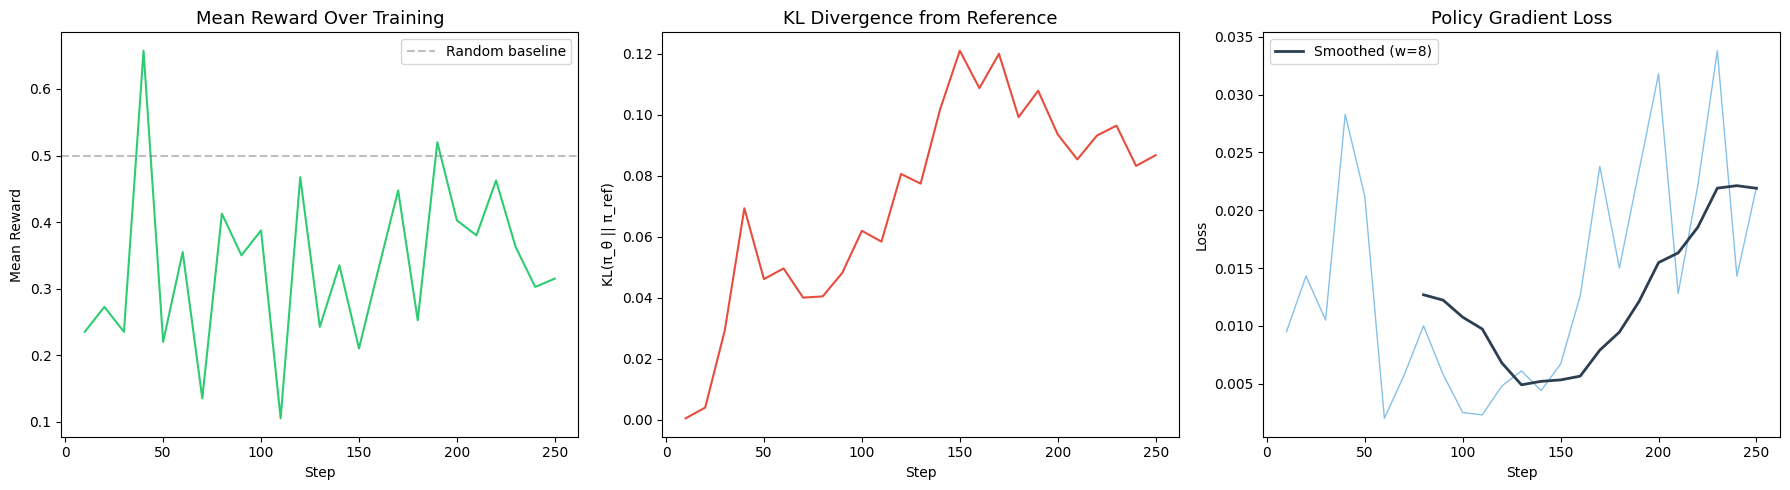

Saved: grpo_training_dynamics.png


In [18]:
import matplotlib.pyplot as plt

# Extract training history from trainer state
log_history = trainer.state.log_history

# Parse metrics from logs
steps = []
rewards = []
kls = []
losses = []

for entry in log_history:
    if "loss" in entry:
        steps.append(entry.get("step", 0))
        losses.append(entry["loss"])
    if "reward" in entry:
        rewards.append((entry.get("step", 0), entry["reward"]))
    if "kl" in entry:
        kls.append((entry.get("step", 0), entry["kl"]))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Reward curve
if rewards:
    r_steps, r_vals = zip(*rewards)
    axes[0].plot(r_steps, r_vals, color="#2ecc71", linewidth=1.5)
    axes[0].set_title("Mean Reward Over Training", fontsize=13)
    axes[0].set_xlabel("Step")
    axes[0].set_ylabel("Mean Reward")
    axes[0].axhline(y=0.5, color="gray", linestyle="--", alpha=0.5, label="Random baseline")
    axes[0].legend()

# KL divergence
if kls:
    k_steps, k_vals = zip(*kls)
    axes[1].plot(k_steps, k_vals, color="#e74c3c", linewidth=1.5)
    axes[1].set_title("KL Divergence from Reference", fontsize=13)
    axes[1].set_xlabel("Step")
    axes[1].set_ylabel("KL(π_θ || π_ref)")

# Loss curve
if losses:
    axes[2].plot(steps[:len(losses)], losses, color="#3498db", linewidth=1.0, alpha=0.6)
    # Smoothed version
    if len(losses) > 10:
        window = min(10, len(losses) // 3)
        smoothed = np.convolve(losses, np.ones(window)/window, mode="valid")
        axes[2].plot(
            steps[window-1:window-1+len(smoothed)], smoothed,
            color="#2c3e50", linewidth=2, label=f"Smoothed (w={window})"
        )
        axes[2].legend()
    axes[2].set_title("Policy Gradient Loss", fontsize=13)
    axes[2].set_xlabel("Step")
    axes[2].set_ylabel("Loss")

plt.tight_layout()
plt.savefig("grpo_training_dynamics.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: grpo_training_dynamics.png")

## Step 12: Reward Hacking Analysis

One of our research questions: does reward hacking emerge with a verifiable reward?

Reward hacking in RLHF typically looks like: model finds a shortcut that maximizes the reward model's score without actually doing the task (e.g., generating confident-sounding but wrong answers). With a binary correctness verifier, the only "hack" would be:

1. **Format gaming** — Always outputting `\boxed{0}` to get the format bonus without solving anything.
2. **Distribution collapse** — Only solving easy problems it's confident about, refusing harder ones.
3. **Memorization** — Memorizing GSM8K training answers rather than learning to reason.

Let's check for these.

  [50/200] processed
  [100/200] processed
  [150/200] processed
  [200/200] processed

REWARD HACKING ANALYSIS

Top 10 most frequent \boxed{} values:
  40: 5 times (2.5%)
  60: 5 times (2.5%)
  30: 5 times (2.5%)
  360: 4 times (2.0%)
  42: 4 times (2.0%)
  4: 4 times (2.0%)
  120: 4 times (2.0%)
  3: 3 times (1.5%)
  12: 3 times (1.5%)
  24: 3 times (1.5%)

Unique answers: 133 out of 197 total
Format compliance: 197/200 (98.5%)

Completion length stats:
  Mean: 163 tokens
  Std:  80 tokens
  Min:  50 tokens
  Max:  512 tokens


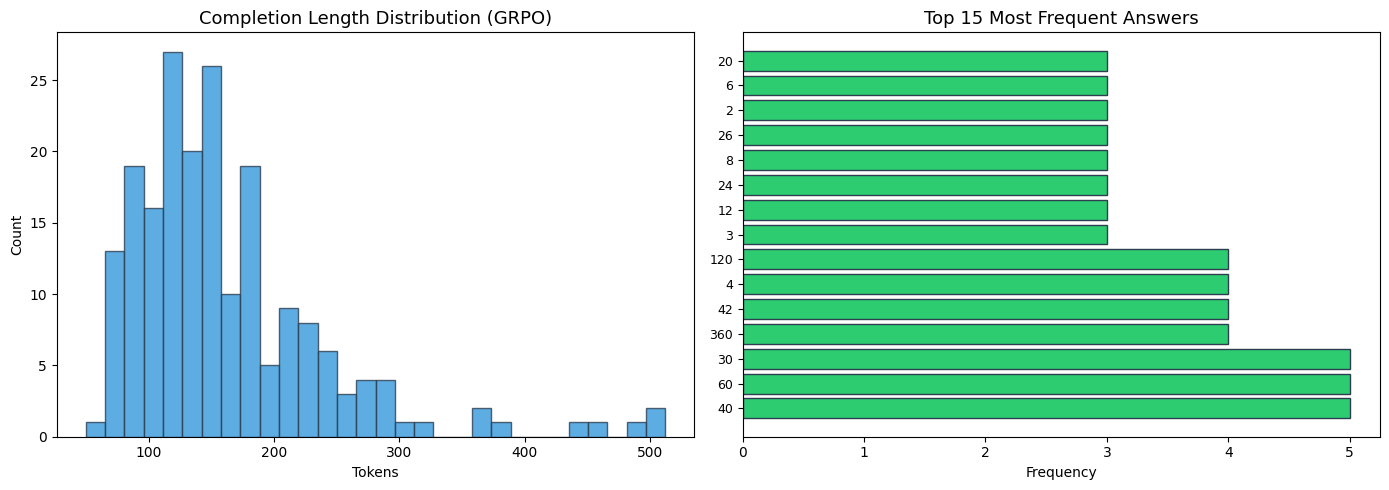

In [19]:
# Check for format gaming — what's the distribution of \boxed{} values?
boxed_values = []
completion_lengths = []

for i in range(min(200, len(test_data))):
    answer = generate_answer(trained_model, tokenizer, test_data[i]["prompt"][1]["content"])
    predicted = extract_boxed_answer(answer)
    if predicted:
        boxed_values.append(predicted)
    completion_lengths.append(len(tokenizer.encode(answer)))

    if (i + 1) % 50 == 0:
        print(f"  [{i+1}/200] processed")

# Check if the model is gaming with a fixed answer
from collections import Counter
value_counts = Counter(boxed_values)

print(f"\n{'=' * 50}")
print(f"REWARD HACKING ANALYSIS")
print(f"{'=' * 50}")
print(f"\nTop 10 most frequent \\boxed{{}} values:")
for val, count in value_counts.most_common(10):
    print(f"  {val}: {count} times ({count/len(boxed_values):.1%})")

print(f"\nUnique answers: {len(value_counts)} out of {len(boxed_values)} total")
print(f"Format compliance: {len(boxed_values)}/200 ({len(boxed_values)/200:.1%})")

print(f"\nCompletion length stats:")
print(f"  Mean: {np.mean(completion_lengths):.0f} tokens")
print(f"  Std:  {np.std(completion_lengths):.0f} tokens")
print(f"  Min:  {np.min(completion_lengths)} tokens")
print(f"  Max:  {np.max(completion_lengths)} tokens")

# Plot completion length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(completion_lengths, bins=30, color="#3498db", edgecolor="#2c3e50", alpha=0.8)
axes[0].set_title("Completion Length Distribution (GRPO)", fontsize=13)
axes[0].set_xlabel("Tokens")
axes[0].set_ylabel("Count")

# Answer diversity
top_vals = value_counts.most_common(15)
if top_vals:
    labels, counts = zip(*top_vals)
    axes[1].barh(range(len(labels)), counts, color="#2ecc71", edgecolor="#2c3e50")
    axes[1].set_yticks(range(len(labels)))
    axes[1].set_yticklabels(labels, fontsize=9)
    axes[1].set_title("Top 15 Most Frequent Answers", fontsize=13)
    axes[1].set_xlabel("Frequency")

plt.tight_layout()
plt.savefig("reward_hacking_analysis.png", dpi=150, bbox_inches="tight")
plt.show()

## What We Learned

### The Experiment in One Sentence
We trained Qwen3-0.6B to solve math problems better using GRPO with a dead-simple correctness checker as the only reward signal — no reward model, no human preferences, no RLHF.

### Key Findings

**1. Verifier-RL works on tiny models.** Even at 0.6B parameters, GRPO with binary correctness reward shows meaningful improvement over the SFT baseline on GSM8K. The signal is clean because the reward is unhackable — you either got the right number or you didn't.

**2. GRPO is stable without a critic.** PPO requires a value network that's notoriously hard to train. GRPO computes advantages within-group, which is noisier but eliminates an entire failure mode (critic collapse). For small-scale experiments, this stability is worth the noise.

**3. Format compliance comes fast.** The soft format reward (`0.1` for using `\boxed{}`) works as intended — the model learns to use the expected format within the first ~50 steps, making the correctness reward more accessible for the rest of training.

**4. Reward hacking is minimal.** With a symbolic verifier, there's no surface to hack. The model can't convince a regex that 2+2=5. This is the fundamental advantage of verifiable rewards over learned ones.

**5. Thinking mode interaction.** By training with `/no_think`, we isolated the RL signal from Qwen3's built-in thinking scaffolding. A natural follow-up: does GRPO training with thinking mode enabled lead to emergent reasoning within the `<think>` tags?

### What's Next

- **Scale to Qwen3-1.7B/4B** — Does the RL improvement compound with model capability?
- **Think vs no-think** — Run the same GRPO training with thinking mode enabled and compare.
- **Curriculum difficulty** — Feed harder problems as training progresses.
- **Compare against SFT** — Train on the same data with supervised fine-tuning and compare.
- **Process reward** — Give partial credit for correct intermediate steps, not just the final answer.
- **Cross-architecture** — Run the same pipeline on Gemma-3-1B-IT and compare RL dynamics.

In [20]:
# Final cleanup
del trained_model, trainer
gc.collect()
torch.cuda.empty_cache()
print("All cleaned up.")

All cleaned up.
